In [134]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as sp
from sklearn.utils import resample
%matplotlib inline

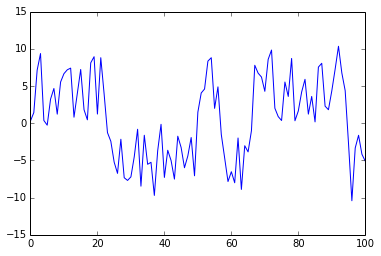

In [315]:
def evolution(x):
    return 0.5*x+25*x/(1+x*x)+8*np.cos(1.2*x)+np.random.normal(0,1.0)

def observation(x):
    return x/2+np.random.normal(0,1.0)

x =1.0
x_list= [1.0]
y_list=[]
for i in range(100):
    x_list.append(x)
    x = evolution(x)

y_list = map(observation,x_list)
###plt.plot(x_list)
plt.plot(y_list)
plt.show()

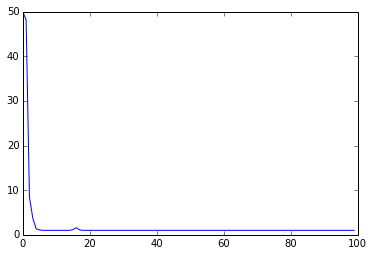

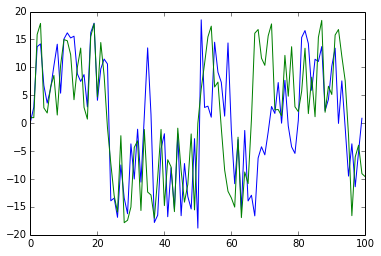

In [352]:
 
M = 50
emsemble = np.random.normal(0.0,1.0,M)
weight = np.ones(M)/M*1.0
forward = emsemble
y_obs = y_list[0]
effective =[]
analysis_sis = []
for j in range(100):
    y_obs = y_list[j]
    ##print "y",y_obs
    effective.append(1/np.sum(weight*weight))
    likelihood =  np.array([sp.norm.pdf(y_obs-i/2.0,0.0,1.0) for i in emsemble])
    ###print emsemble
    weight = likelihood*weight
    weight = weight/np.sum(weight)
    analysis_sis.append(np.sum(weight*emsemble))
    emsemble = map(evolution,emsemble)

plt.plot(effective)
plt.show()

plt.plot(analysis_sis)
plt.plot(x_list)
plt.show()


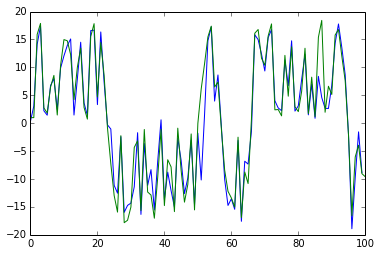

In [353]:
from numpy.random import random


def residual_resample(weights):
    N = len(weights)
    indexes = np.zeros(N, 'i')

    # take int(N*w) copies of each weight, which ensures particles with the
    # same weight are drawn uniformly
    num_copies = (np.floor(N*np.asarray(weights))).astype(int)
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormal resample on the residual to fill up the rest. This
    # maximizes the variance of the samples
    residual = weights - num_copies     # get fractional part
    residual /= sum(residual)           # normalize
    cumulative_sum = np.cumsum(residual)
    cumulative_sum[-1] = 1. # avoid round-off errors: ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes


M = 50
emsemble = np.random.normal(0.0,1.0,M)
forward = emsemble
y_obs = y_list[0]
effective =[]
analysis_sir = []

for j in range(100):
    y_obs = y_list[j]
    ##print "y",y_obs
    effective.append(1/np.sum(weight*weight))
    likelihood =  np.array([sp.norm.pdf(y_obs-i/2.0,0.0,1.0) for i in emsemble])
    index = residual_resample(likelihood/np.sum(likelihood))
    new_emsemble = np.array([emsemble[i] for i in index])
    analysis_sir.append(np.mean(new_emsemble))
    emsemble = map(evolution,new_emsemble)

plt.plot(analysis_sir)
plt.plot(x_list)
plt.show()


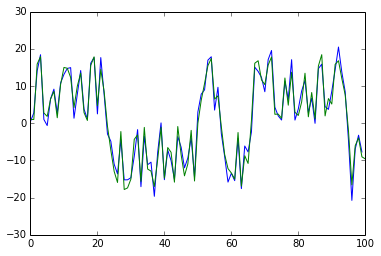

In [354]:
M = 50
emsemble = np.random.normal(0.0,1.0,M)
forward = emsemble
y_obs = y_list[0]
effective =[]
analysis_enkf = []

for i in range(100):
    cov = np.sum(np.power(emsemble-np.mean(emsemble),2))
    kalman = cov*0.5/(0.25*cov+1)
    new_emsemble = emsemble-kalman*(0.5*emsemble+np.random.normal(0,1,M)-y_list[i])
    analysis_enkf.append(np.mean(new_emsemble))
    emsemble = evolution(new_emsemble)
    
plt.plot(analysis_enkf)
plt.plot(x_list)
plt.show()

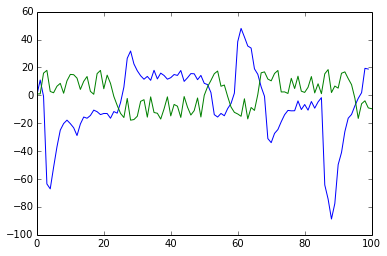

In [355]:
M = 50
emsemble = np.random.normal(0.0,1.0,M)
forward = emsemble
y_obs = y_list[0]
effective =[]
analysis_esrf = []

###print np.dot(A[:,np.newaxis],A[np.newaxis,:])
for i in range(100):
    A = emsemble-np.mean(emsemble)
    pesdo_S = np.identity(M)+1.0/(M-1)*np.dot(A[:,np.newaxis],A[np.newaxis,:])*0.25
    S = np.linalg.inv(np.linalg.cholesky(pesdo_S))
    analysis_mean = np.mean(emsemble)-1.0/(M-1)*np.dot(np.dot(A,np.dot(S,S)),A)*0.5*(0.5*np.mean(emsemble)-y_list[i])
    new_emsemble = analysis_mean+ np.dot(emsemble,S)-np.mean(emsemble)
    emsemble = new_emsemble
    analysis_esrf.append(np.mean(new_emsemble))
    emsemble = map(evolution,new_emsemble)

    
plt.plot(analysis_esrf)
plt.plot(x_list)
plt.show()

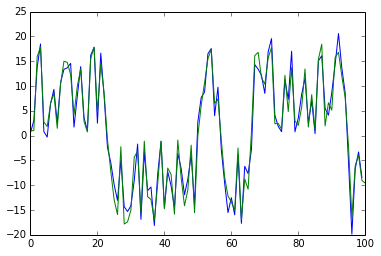

In [356]:
M = 50
emsemble = np.random.normal(0.0,1.0,M)
forward = emsemble
y_obs = y_list[0]
effective =[]
analysis_esrf2 = []

for i in range(100):
    
    cov_f = np.sum(np.power(emsemble-np.mean(emsemble),2))
    kalman = cov_f*0.5/(0.25*cov_f+1)
    cov_a = cov_f-kalman*0.5*cov_f
    a_mean = np.mean(emsemble)-cov_a*0.5*(0.5*np.mean(emsemble)-y_list[i])
    new_emsemble= a_mean+np.sqrt(cov_a/cov_f)*(emsemble-np.mean(emsemble))
    emsemble = new_emsemble 
    analysis_esrf2.append(np.mean(new_emsemble))
    emsemble = map(evolution,new_emsemble)

    
plt.plot(analysis_esrf2)
plt.plot(x_list)
plt.show()

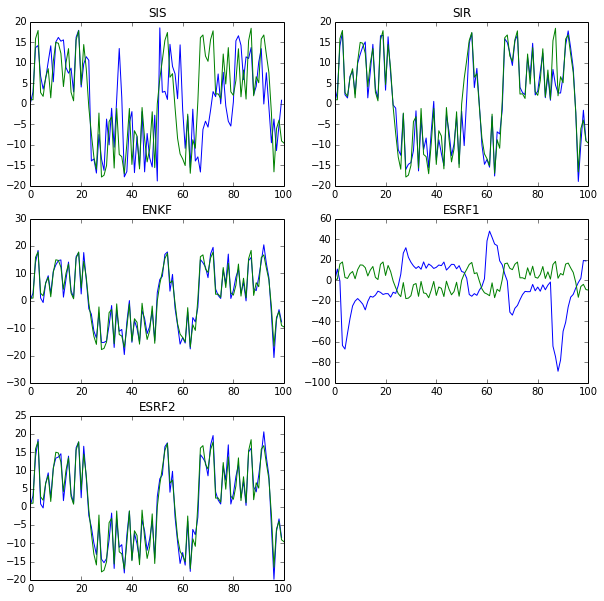

In [357]:
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.plot(analysis_sis)
plt.plot(x_list)
plt.title("SIS")
plt.subplot(3,2,2)
plt.plot(analysis_sir)
plt.plot(x_list)
plt.title("SIR")
plt.subplot(3,2,3)
plt.plot(analysis_enkf)
plt.plot(x_list)
plt.title("ENKF")
plt.subplot(3,2,4)
plt.plot(analysis_esrf)
plt.title("ESRF1")
plt.plot(x_list)
plt.subplot(3,2,5)
plt.plot(analysis_esrf2)
plt.title("ESRF2")
plt.plot(x_list)
plt.savefig("all")
plt.show()